In [411]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings

from functools import reduce
from pattern_search import *
from rapidfuzz import fuzz
from sentence_transformers import SentenceTransformer, util

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [412]:
def string_matching_score(x, f, metric='similarity'):
    query = x[0]
    matches = x[1]
    match_score = {}
    for match in matches:
        match_score[match] = f(query, match)
    reverse=True
    if metric == 'distance':
        reverse=False
    return sorted(match_score.items(), key = lambda x: x[1], reverse=reverse)

In [413]:
def precision_at(k, search_results, relevant_docs):
    actual_positives = len(relevant_docs)
    true_positives = 0
    for search_result in search_results[0:k]:
        if search_result in relevant_docs:
            true_positives += 1
    return true_positives / k

In [414]:
def recall_at(k, search_results, relevant_docs):
    actual_positives = len(relevant_docs)
    true_positives = 0
    for search_result in search_results[0:k]:
        if search_result in relevant_docs:
            true_positives += 1
    return true_positives / actual_positives

In [415]:
def precision_till(k, ranked_list, relevant_docs):
    precision_list = []
    for i in range(1, k+1, 1):
        precision_list.append(precision_at(i, ranked_list, relevant_docs))
    return precision_list

In [416]:
def recall_till(k, ranked_list, relevant_docs):
    recall_list = []
    for i in range(1, k+1, 1):
        recall_list.append(recall_at(i, ranked_list, relevant_docs))
    return recall_list

In [417]:
def avg_precision_till(k, ranker_lists, relevant_docs_list):
    precision_sum = np.zeros(k)
    for ranker_list, relevant_docs in zip(ranker_lists, relevant_docs_list):
        precision_sum += np.array(precision_till(k, ranker_list, relevant_docs))
    return precision_sum / len(relevant_docs_list)

In [418]:
def avg_recall_till(k, ranker_lists, relevant_docs_list):
    recall_sum = np.zeros(k)
    for ranker_list, relevant_docs in zip(ranker_lists, relevant_docs_list):
        recall_sum += np.array(recall_till(k, ranker_list, relevant_docs))
    return recall_sum / len(relevant_docs_list)

In [419]:
def average_precision(ranker_list, relevant_docs):
    states = [match in relevant_docs for match in ranker_list]
    k_values = np.where(states)[0] + 1
    precision_sum = 0
    for k in k_values:
        precision_sum += precision_at(k, ranker_list, relevant_docs)
    return precision_sum / len(k_values)

In [420]:
def mean_average_precision(ranker_lists, relevant_docs_list, return_ap = False):
    avg_precision_sum = 0
    ap_list = []
    for ranker_list, relevant_docs in zip(ranker_lists, relevant_docs_list):
        ap = average_precision(ranker_list, relevant_docs)
        ap_list.append(ap)
        avg_precision_sum += ap
    mean_avg_precision = avg_precision_sum / len(relevant_docs_list)
    if return_ap == True:
        return mean_avg_precision, ap_list
    return mean_avg_precision

In [421]:
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [422]:
from torch.nn import PairwiseDistance
def vector_space_score(x, distance, embedder, matches, match_embeddings, subset=False, k=100):
    ingredient = x[0]
    if subset==True:
        matches = x[1]
        match_embeddings = embedder.encode(matches, convert_to_tensor=True)
        k=len(matches)
    match_score = {}
    if len(matches) > 0:
        ingredient_embedding = embedder.encode(ingredient, convert_to_tensor=True)
        if distance == 'cosine':
            scores = util.pytorch_cos_sim(ingredient_embedding, match_embeddings)[0]
            reverse = True
        else:
            pdist = PairwiseDistance(p=2)
            scores = pdist(ingredient_embedding, match_embeddings)
            reverse = False
    #     top_results = torch.topk(cos_scores, k=5)
        match_score= dict(zip(matches, scores.numpy()))
        match_score = sorted(match_score.items(), key = lambda x: x[1], reverse=reverse)
    return match_score[0:k]

In [423]:
def tokenizer1(text):
    return list(set(text.split()))

import nltk
def tokenize(text):
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2]  # ignore a, an, to, at, be, ...
    return tokens

def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(w) for w in words]
    return stemmed

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
def tokenizer2(text):
    tokens = tokenize(text)
    tokenized_words = [t for t in tokens if t not in ENGLISH_STOP_WORDS] 
    return stemwords(tokenized_words)

from sklearn.feature_extraction.text import TfidfVectorizer
def compute_tfidf(corpus, tokenizer):
    """
    Create and return a TfidfVectorizer object after training it on
    the list of articles pulled from the corpus dictionary. Meaning,
    call fit() on the list of document strings, which figures out
    all the inverse document frequencies (IDF) for use later by
    the transform() function. The corpus argument is a dictionary 
    mapping file name to xml text.
    """
    tfidf = TfidfVectorizer(input='content',
                            analyzer='word',
                            tokenizer=tokenizer,
                            stop_words='english', # even more stop words
                            decode_error = 'ignore')
    tfidf.fit(corpus)
    return tfidf

from sklearn.metrics import pairwise_distances
def vector_space_score_tfidf(x, matches, matches_tfidf, subset=False, k=100):
    if subset==True:
        matches = x[1]
        matches_tfidf = tfidf_model.transform(matches)
        k=len(matches)
    ingredient = x[0]
    match_score = {}
    if len(matches) > 0:
        ingredient_tfidf = tfidf_model.transform([ingredient])
        pair_distances = pairwise_distances(ingredient_tfidf, matches_tfidf)[0]
        match_score = dict(zip(matches, pair_distances))
        match_score = sorted(match_score.items(), key = lambda x: x[1], reverse=False)
    return match_score[0:k]

from sklearn.metrics import pairwise_distances
def vector_space_score_tfidf_description(x, matches, matches_tfidf, tfidf_model, subset=False, k=100):
    if subset==True:
        matches = x[1]
        matches_tfidf = tfidf_model.transform(matches)
        k=len(matches)
    ingredient = x[0]
    match_score = {}
    if len(matches) > 0:
        ingredient_tfidf = tfidf_model.transform([ingredient])
        pair_distances = pairwise_distances(ingredient_tfidf, matches_tfidf)[0]
        match_score = dict(zip(matches, pair_distances))
        match_score = sorted(match_score.items(), key = lambda x: x[1], reverse=False)
    return match_score[0:k]

In [424]:
top_100_ingredients = pd.read_csv('data/top_100_ingredients.csv')

In [425]:
top_100_ingredients

,ingredients,recipe_counts
0,salt,293793
1,sugar,182598
2,water,120372
3,olive oil,109219
4,butter,100693
5,milk,79429
6,flour,78527
7,all-purpose flour,77573
8,baking powder,63980
9,eggs,62989


In [426]:
# Preprocess Target data
ip_file_dir = "../Data/Target Data/"
group10 = pd.read_csv(os.path.join(ip_file_dir, 'group10_header.csv'),
                      sep='\t', low_memory=False)
op_file_path = os.path.join(ip_file_dir, 'scraped/products.csv')
products = pd.read_csv(op_file_path)
group10 = pd.merge(group10, products, how = 'left', on = 'tcin')
group10 = group10[~pd.isnull(group10['title'])]
group10['title_lower'] = group10['title'].str.lower()
group10['title_lower'] = group10['title_lower'].apply(lambda x: re.sub(r'[0-9]+(.)?([0-9]+)?[\s]*(cans|can|boxes|box|bottles|bottle|gallons|gallon|fl oz|oz|fl|gal|pk|ct|ml|lbs|lb|qt|pt|ounce|0z|l|g)\b', '', x))
regex = re.compile(r'[' + string.punctuation + '0-9\r\t\n]')
group10['title_lower'] = group10['title_lower'].apply(lambda x: regex.sub("", x))
group10['title_lower'] = group10['title_lower'].apply(lambda x: re.sub("[\s]+", " ", x))
group10['title_lower_stemmed']= group10['title_lower'].apply(stem_ingredient)

In [455]:
# Find relevant salt products
salt_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SALTS'))
                   |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SALT')))
                   | ((group10['item_type_name'] == 'Spices and Herbs')
                    & (group10['short_desc'].str.contains('SALT')))]

# Find relevant sugar products
sugar_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SUGAR'))
                    |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SUGAR')))
                    |((group10['item_type_name'] == 'Sugars and Sweeteners')
                    & (group10['short_desc'].str.contains('SUGAR')))]

# Find relevant water products
water_docs = group10[(group10['class_name'] == "DC BASE WATER")]

# Find relevant olive oil products
olive_oil_docs = group10[(group10['subclass_name'] == 'OLIVE OILS')
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['short_desc'].str.contains('OLIVE OIL')))
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['style_name'].str.contains('OLIVE SPRAY')))]


# Get product list from docs
salt_relevant_docs = list(salt_docs['title_lower'].values)
sugar_relevant_docs = list(sugar_docs['title_lower'].values)
water_relevant_docs = list(water_docs['title_lower'].values)
olive_oil_relevant_docs = list(olive_oil_docs['title_lower'].values)

# Create ingredient and relevant products mapping
ingredient_docs_map = {}
ingredient_docs_map = dict.fromkeys(['salt', 'pinch salt', 'kosher salt', 'sea salt'], salt_relevant_docs)
ingredient_docs_map.update(dict.fromkeys(['sugar', 'granulated sugar', 
                                          'white sugar', 'powdered sugar',
                                          'packed brown sugar', 'confectioners sugar'], sugar_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['water'], water_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['olive oil', 'extra virgin olive oil',
                                          'vegetable oil', 'oil'], olive_oil_relevant_docs))

In [456]:
ingredient = 'olive oil'

In [457]:
pm = PatternMatcher(group10, k=10)
# pm.search_exact('sugar')

In [458]:
# group10[group10['title_lower'] == 'morton extra coarse sea salt grinder refill ']

In [459]:
# Pattern Ranker
exact_matches = pm.search_exact(ingredient)
stem_matches = pm.search_stem(ingredient)
# hypernym_matches = pm.search_hypernym(ingredient)
# hyponyms_matches = pm.search_hyponyms(ingredient)
noun_matches = pm.search_noun(ingredient)
noun_multiple_matches = pm.search_noun_multiple(ingredient)
longest_match_backward_matches = pm.longest_match(ingredient, 'backward')
longest_match_forward_matches = pm.longest_match(ingredient, 'forward')
noun_multiple_combined_matches = flatten_dict(noun_multiple_matches)
search_matches = list(set(exact_matches + stem_matches  \
                       + noun_matches + longest_match_backward_matches \
                       + longest_match_forward_matches + noun_multiple_combined_matches))

pattern_ranker_score = string_matching_score((ingredient, search_matches),
                                            fuzz.token_set_ratio, 
                                            metric='similarity')
pattern_ranker_list = [item[0] for item in pattern_ranker_score]

In [460]:
relevant_docs = list(olive_oil_docs['title_lower'].values)
# df = pd.DataFrame()
# df['search_results'] = pattern_ranker_list
# df['relevant'] = df['search_results'].apply(lambda x: x in relevant_docs)
# df

In [451]:
# Get embeddings for Sentence Transformers 
lm_embedder = SentenceTransformer('all-MiniLM-L6-v2')
glove_embedder = SentenceTransformer('average_word_embeddings_glove.6B.300d')

all_matches = group10['title_lower'].values
# glove_embeddings = glove_embedder.encode(all_matches, convert_to_tensor=True)
# lm_embeddings = lm_embedder.encode(all_matches, convert_to_tensor=True)
# joblib.dump(glove_embeddings, 'data/glove_embeddings')
# joblib.dump(lm_embeddings, 'data/lm_embeddings')
glove_embeddings = joblib.load('data/glove_embeddings')
lm_embeddings = joblib.load('data/lm_embeddings')

In [452]:
# Get rankings for single ingredient
glove_ranker_score = vector_space_score((ingredient, ), 'cosine',
                                        glove_embedder,
                                        all_matches,
                                        glove_embeddings,
                                        subset=False)
glove_ranker_list = [item[0] for item in glove_ranker_score]

lm_ranker_score = vector_space_score((ingredient, ), 'cosine',
                                        lm_embedder,
                                        all_matches,
                                        lm_embeddings,
                                        subset=False)
lm_ranker_list = [item[0] for item in lm_ranker_score]

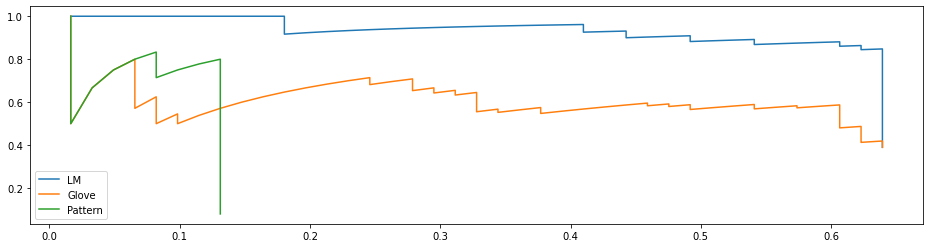

In [453]:
# Precision-Recall Plot for single ingredient
lm_precision_list = precision_till(100, lm_ranker_list, relevant_docs)
lm_recall_list = recall_till(100, lm_ranker_list, relevant_docs)
glove_precision_list = precision_till(100, glove_ranker_list, relevant_docs)
glove_recall_list = recall_till(100, glove_ranker_list, relevant_docs)
pattern_precision_list = precision_till(100, pattern_ranker_list, relevant_docs)
pattern_recall_list = recall_till(100, pattern_ranker_list, relevant_docs)
ranks = list(range(1, 101, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(lm_recall_list, lm_precision_list, label='LM')
ax.plot(glove_recall_list, glove_precision_list, label='Glove')
ax.plot(pattern_recall_list, pattern_precision_list, label='Pattern')
plt.legend()
plt.show()

In [454]:
print(f'Glove AP: {average_precision(glove_ranker_list, relevant_docs):.2f}')
print(f'LM AP: {average_precision(lm_ranker_list, relevant_docs):.2f}')

Glove AP: 0.62
LM AP: 0.94


In [461]:
# Get rankings for multiple ingredients

ingredients = ingredient_docs_map.keys()
relevant_docs_list = ingredient_docs_map.values()

# Glove rankings
glove_ranker_lists = []
for ingredient in ingredients:
    glove_ranker_score = vector_space_score((ingredient, ), 'cosine',
                                        glove_embedder,
                                        all_matches,
                                        glove_embeddings,
                                        subset=False)
    glove_ranker_list_temp = [item[0] for item in glove_ranker_score]
    glove_ranker_lists.append(glove_ranker_list_temp)
    
glove_map, glove_ap = mean_average_precision(glove_ranker_lists, relevant_docs_list, return_ap = True)
print(f'Glove MAP: {glove_map: .2f}')
    
# LM rankings
lm_ranker_lists = []
for ingredient in ingredients:
    lm_ranker_score = vector_space_score((ingredient, ), 'cosine',
                                        lm_embedder,
                                        all_matches,
                                        lm_embeddings,
                                        subset=False)
    lm_ranker_list_temp = [item[0] for item in lm_ranker_score]
    lm_ranker_lists.append(lm_ranker_list_temp)
    
lm_map, lm_ap = mean_average_precision(lm_ranker_lists, relevant_docs_list, return_ap = True)
print(f'LM MAP: {lm_map:.2f}')
    
# TF-IDF using title
tfidf_model = compute_tfidf(all_matches, tokenizer1)
all_matches_tfidf = tfidf_model.transform(all_matches)
tfidf_ranker_lists = []
for ingredient in ingredients:
    tfidf_ranker_score = vector_space_score_tfidf((ingredient, ),
                                                 all_matches,
                                                 all_matches_tfidf,
                                                 subset=False)
    tfidf_ranker_list_temp = [item[0] for item in tfidf_ranker_score]
    tfidf_ranker_lists.append(tfidf_ranker_list_temp)
    
tfidf_map, tfidf_ap = mean_average_precision(tfidf_ranker_lists, relevant_docs_list, return_ap = True)
print(f'TFIDF MAP: {tfidf_map:.2f}')

# TF-IDF using description
group10_description = group10[(group10['description'].str.len() > 10)]
all_matches_description = group10_description['description'].values
all_matches_products = group10_description['title_lower'].values
# tfidf_model_description = compute_tfidf(all_matches_description, tokenizer2)
# all_matches_description_tfidf = tfidf_model_description.transform(all_matches_description)
# joblib.dump(tfidf_model_description, 'data/tfidf_model_description')
# joblib.dump(all_matches_description_tfidf, 'data/all_matches_description_tfidf')
tfidf_model_description = joblib.load('data/tfidf_model_description')
all_matches_description_tfidf = joblib.load('data/all_matches_description_tfidf')

tfidf_description_ranker_lists = []
for ingredient in ingredients:
    tfidf_description_ranker_score = vector_space_score_tfidf_description((ingredient, ),
                                                 all_matches_products,
                                                 all_matches_description_tfidf,
                                                 tfidf_model_description,
                                                 subset=False)
    tfidf_description_ranker_list = [item[0] for item in tfidf_description_ranker_score]
    tfidf_description_ranker_lists.append(tfidf_description_ranker_list)
    
tfidf_description_map, tfidf_description_ap = mean_average_precision(tfidf_description_ranker_lists, 
                                                                     relevant_docs_list, 
                                                                     return_ap = True)
print(f'TFIDF (Description) MAP: {tfidf_description_map:.2f}')

Glove MAP:  0.59
LM MAP: 0.61
TFIDF MAP: 0.48
TFIDF (Description) MAP: 0.51


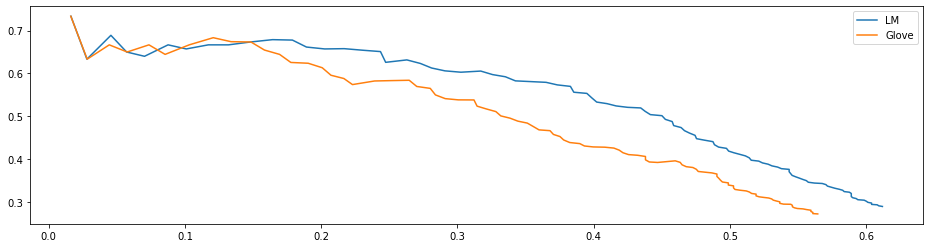

In [462]:
# Precision-Recall Plot for multiple ingredients
lm_avg_precision_list = avg_precision_till(100, lm_ranker_lists, relevant_docs_list)
lm_avg_recall_list = avg_recall_till(100, lm_ranker_lists, relevant_docs_list)
glove_avg_precision_list = avg_precision_till(100, glove_ranker_lists, relevant_docs_list)
glove_avg_recall_list = avg_recall_till(100, glove_ranker_lists, relevant_docs_list)
ranks = list(range(1, 101, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(lm_avg_recall_list, lm_avg_precision_list, label='LM')
ax.plot(glove_avg_recall_list, glove_avg_precision_list, label='Glove')
plt.legend()
plt.show()

In [463]:
# Compare APs at ingredient level
dfs = [create_ap_df(ingredients, glove_ap, 'glove_ap'),
       create_ap_df(ingredients, lm_ap, 'lm_ap'),
       create_ap_df(ingredients, tfidf_ap, 'tfidf_ap'),
       create_ap_df(ingredients, tfidf_description_ap, 'tfidf_description_ap')]
df_final = reduce(lambda left, right: pd.merge(left, right, on='ingredient'), dfs)

pd.options.display.float_format = '{:,.1f}'.format
df_final

,ingredient,glove_ap,lm_ap,tfidf_ap,tfidf_description_ap
0,salt,0.7,0.7,0.7,0.8
1,pinch salt,0.7,0.4,0.5,0.4
2,kosher salt,0.6,0.5,0.3,0.8
3,sea salt,0.5,0.6,0.4,0.4
4,sugar,0.7,0.8,0.5,0.4
5,granulated sugar,0.8,0.8,0.5,0.4
6,white sugar,0.6,0.8,0.4,0.5
7,powdered sugar,0.7,0.8,0.5,0.5
8,packed brown sugar,0.6,0.8,0.4,0.5
9,confectioners sugar,0.7,0.7,0.6,0.5
